In [ ]:
import cv2 
import os

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        img = read(PATH)
           
        img = cv2.resize(img, (RESIZE,RESIZE))
           
        IMG.append(np.array(img))
    return IMG


In [ ]:
from PIL import Image

In [ ]:
data_path_c="D:\dl_dataset/lungs-xray/COVID PATIENTS/COVID"
data_path_n="D:\dl_dataset/lungs-xray/NORMAL PATIENTS/NORMAL"


In [ ]:
import numpy as np
from tqdm import tqdm

In [ ]:
covid_train = np.array(Dataset_loader(data_path_c,150))
normal_train = np.array(Dataset_loader(data_path_n,150))

100%|████████████████████████████████████████| 162/162 [00:08<00:00, 19.64it/s]


In [ ]:
covid_train_label = np.zeros(len(covid_train))
normal_train_label = np.ones(len(normal_train))

In [ ]:
X_train = np.concatenate((covid_train, normal_train), axis = 0)
Y_train = np.concatenate((covid_train_label,normal_train_label), axis = 0)

In [ ]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes= 2)

Using TensorFlow backend.


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    train_size=0.8,
    random_state=5
)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator()

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from keras.applications import DenseNet201 
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import layers

In [ ]:

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=10),
    steps_per_epoch=x_train.shape[0] / 10,
    epochs=20,
    validation_data=(x_train[:20], y_train[:20]),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
26/25 [==============================] - 2806s 108s/step - loss: 0.5361 - accuracy: 0.7085 - val_loss: 0.5777 - val_accuracy: 0.7000


E:\New folder\envs\computervision-env\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
E:\New folder\envs\computervision-env\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/20
26/25 [==============================] - 251s 10s/step - loss: 0.2041 - accuracy: 0.9228 - val_loss: 0.3643 - val_accuracy: 0.8250
Epoch 3/20
26/25 [==============================] - 53032s 2040s/step - loss: 0.1045 - accuracy: 0.9730 - val_loss: 0.2608 - val_accuracy: 0.8000
Epoch 4/20
26/25 [==============================] - 245s 9s/step - loss: 0.1058 - accuracy: 0.9691 - val_loss: 0.0393 - val_accuracy: 1.0000
Epoch 5/20
26/25 [==============================] - 250s 10s/step - loss: 0.0518 - accuracy: 0.9826 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 6/20
26/25 [==============================] - 242s 9s/step - loss: 0.0491 - accuracy: 0.9865 - val_loss: 0.0201 - val_accuracy: 1.0000
Epoch 7/20
26/25 [==============================] - 247s 10s/step - loss: 0.0589 - accuracy: 0.9846 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 8/20
26/25 [==============================] - 245s 9s/step - loss: 0.0300 - accuracy: 0.9961 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch

In [ ]:
Y_pred_tta=model.predict(x_val)

In [ ]:
import matplotlib.pyplot as plt

<AxesSubplot:>

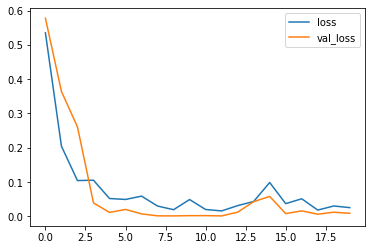

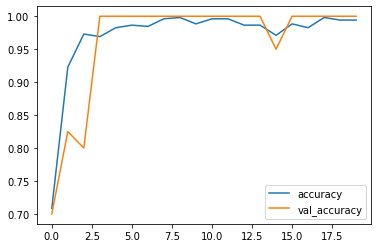

In [ ]:

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

Confusion matrix, without normalization
[[29  5]
 [ 0 31]]


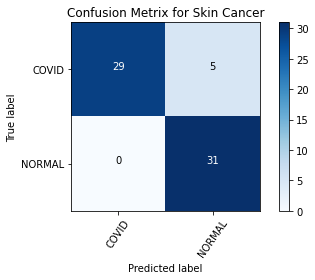

In [ ]:
import itertools
from sklearn.metrics import classification_report
classification_report( np.argmax(y_val, axis=1), np.argmax(Y_pred_tta, axis=1))

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['COVID','NORMAL']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

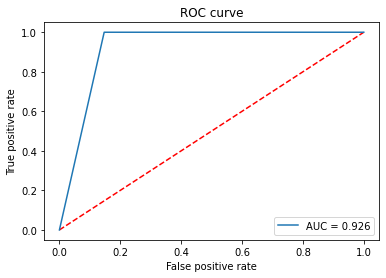

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()